# Coding Tutorial 4 - Convolutional Neural Networks

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```


## Overview

Sections:
- GPU computing resource
- CNN model architecture and training
- Deep CNN model and vanishing gradients
- Batch normalization layers
- Dropout layers
- Residual networks

Objectives:
- Learn to train with a GPU instead of a CPU
- Learn to build and train a CNN model
- Observe vanishing gradients in deep CNN
- Implement batch normalization, dropout, and residual networks


### GPU Computing Resource

Using GPUs for training can dramatically speed up the process. To leverage GPUs on a local device, you will need to install `cuda` and `pytorch` cuda version. In colab, we can just change the runtime setting in the menu bar:

**Runtime** -> **Change runtime type** --> **GPU**

Run this cell to confirm the available device. If the GPU(s) are detected, this cell should print:
```
Using device: cuda
```
Otherwise, this will print:
```
Using device: cpu
```

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Convolutional Neural Networks (CNN)

Convolutional Neural Networks (CNN) are widely used for **image classification** tasks due their ability to capture spatial features using convolutional layers. In this tutorial, we will implement a basic CNN in PyTorch and train it on the MNIST dataset.

### Installations and Imports

In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchsummary import summary
from torchvision.transforms import v2
from torch.utils.data import DataLoader

In [3]:
import numpy as np
import pandas as pd

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [4]:
from torchmetrics.classification import Accuracy

/Users/dna-tuananguyen/anaconda3/envs/nndl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

#### Read Data

We will load a dataset from `torchvision.datasets`. You can find the full list of available image classification datasets [here](https://pytorch.org/vision/0.20/datasets.html#image-classification).

Then, we will use [`torchvision.transforms.v2`](https://pytorch.org/vision/stable/transforms.html) to perform basic computer vision transformations. This package has most of the data pre-processing steps we need for image data, including *image normalization*, *data augmentation*, and *resizing*.


In [5]:
# Define transformations: Convert images to tensors
transform = v2.Compose([
    v2.ToTensor()
])

# Load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
print('Train set size: {}, test set size: {}'.format(len(train_dataset), len(test_dataset)))

/Users/dna-tuananguyen/anaconda3/envs/nndl/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 9.91M/9.91M [00:00<00:00, 9.92MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.31MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.95MB/s]

Train set size: 60000, test set size: 10000


Print/plot the first sample. To visualize an image, we can use `plt.imshow(image)`.

x sample size: torch.Size([1, 28, 28]), y value (int): 5


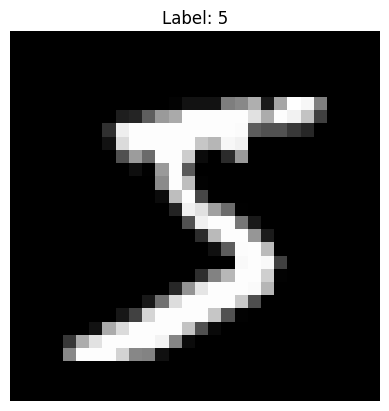

In [6]:
# Grab the first sample and print data shape
x_sample, y_sample = train_dataset[0]
print('x sample size: {}, y value (int): {}'.format(x_sample.shape, y_sample))

# Plot the first sample of Z
import matplotlib.pyplot as plt
plt.imshow(x_sample[0], cmap='gray')
plt.title(f"Label: {y_sample}")
plt.axis('off')
plt.show()

#### DataLoader

[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) helps handle the data batches.

- Assign `batch_size` for your training. The batch size plays a crucial role in training efficiency, memory usage, and model performance. A larger batch size is typically preferred. However, a larger batch size requires more memory, and your code might crash when the memory can't hold all the data in a batch. While we start with setting `256` as the batch size, you can try to increase/decrease the batch size to see what happens.
- Choose to `shuffle` the loaded **training** data in order to randomly order all examples for each epoch.  Providing diverse mini-batches for gradient updates will prevent the model from learning patterns based on the data sequence, helping improve model generalization by reducing chances of overfitting. For the validation/testing data, we don't need to shuffle the batches since there is no learning.


In [7]:
# Create DataLoaders for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

### Model Architecture

Similar to building the MLP models, we use the model base class `nn.Module` to create our CNN model. Review the steps we did for creating a model:
1. `super().__init__()`: inherit and initialize the parent class `nn.Module`
2. Declare all layers in `__init__()`
3.  Define forward pass in `forward(self, x)`


The basic model layers we use in CNN are:
- `nn.Conv2d`
- `nn.MaxPool2d`

An example of a CNN model architecture is [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-convolutional-neural-network). Tips for building a CNN model are:
- The input channel size should match your data. For instance, a greyscale image has 1 channel, and a color image typically has 3 channels (e.g., RGB).
- The size of `out_channels` should match the size of `in_channels` of the next layer.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__() # make sure that the parent class (nn.Module) is properly initialized

        self.n_channels = n_channels
        self.n_classes = n_classes

        # Declare all layers used in this model
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        # First convolution and pooling pass
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.pool1(x)

        # Second convolution and pooling pass
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool2(x)

        # Flatten the features (the first dimention is batch size)
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

For the `forward` function, an alternative coding style is to pass on data through multiple layers in one line. For instance,
```
x = self.pool1(torch.sigmoid(self.conv1(x)))
x = self.pool2(torch.sigmoid(self.conv2(x)))
x = x.view(-1, 64 * 7 * 7)
x = self.fc2(torch.sigmoid(self.fc1(x)))
```
We'll be using this technique in the following sections to construct deeper models.

#### Feature Maps

For each layer, calculate the size of the features:

**[Convolution Layer]**

Assume the size of the input features is $(C_1, L_1, L_1)$ and the size of the output features is $(C_2, L_2, L_2)$. The padding size of the layer is $p$, the kernel size is $k$, the stride is $s$. Then we have:

- $L_2 = \frac{L_1 - k + 2p}{s} + 1$

- $C_2$ is dynamic, assigned in the architecture.

**[Pooling Layer]**

Assume the size of the input features is $(C_1, L_1, L_1)$ and the size of the output features is $(C_2, L_2, L_2)$. The stride is $s$. Then we have:

- $L_2 = \frac{L_1}{s}$

- $C_2 = C_1$



Therefore, we have the following feature sizes:
- Input image size: $(1, 28, 28)$
- Layer `self.conv1`: $k = 3$, $p = 1$, $s = 1$
- Feature size after `self.conv1`: $(C_{conv1}, 28, 28)$
- Layer `self.pool1`: $s = 2$
- Feature size after `self.pool1`: $(C_{conv1}, 14, 14)$
- Layer `self.conv1`: $k = 3$, $p = 1$, $s = 1$
- Feature size after: `self.conv2`: $(C_{conv2}, 14, 14)$
- Layer `self.pool2`: $s = 2$
- Feature size after: `self.pool2`: $(C_{conv2}, 7, 7)$

Now, let's pass in the data with MNIST image size $(1, 28, 28)$ to summarize the model architecture. The output shape of each layer should resemble what we calculated.

In [ ]:
model = SimpleCNN(n_channels=1, n_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [11]:
for images, labels in train_loader:
    print(type(images), images.shape)
    # print(images.shape, labels.shape)

<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torch.Tensor'> torch.Size([256, 1, 28, 28])
<class 'torc

### Model Training

In [9]:
n_channels = 1
n_classes = 10

model = SimpleCNN(n_channels=n_channels, n_classes=n_classes).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
num_epochs = 5
losses = []
gradients = {name:[] for name, param in model.named_parameters() if 'conv' in name and 'weight' in name}
for epoch in range(num_epochs):
    batch_losses = []
    accuracy_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        accuracy_metric.update(outputs, labels)

    train_loss = np.mean(np.array(batch_losses))
    train_acc = accuracy_metric.compute().item()
    losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

# Evaluate on the test set
model.eval()
accuracy_metric.reset()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        accuracy_metric.update(outputs, labels)
test_acc = accuracy_metric.compute().item()
print(f"Evaluation results - Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")

Epoch [1/5], Loss: 1.6926, Accuracy: 43.40%
Epoch [2/5], Loss: 0.4035, Accuracy: 88.66%
Epoch [3/5], Loss: 0.2445, Accuracy: 92.90%
Epoch [4/5], Loss: 0.1700, Accuracy: 94.99%
Epoch [5/5], Loss: 0.1286, Accuracy: 96.27%
Evaluation results - Train Accuracy: 96.27%, Test Accuracy: 96.55%


## Deep CNN

In the lecture, we learned that the CNN architectures growing deeper and deeper, and how **vanishing gradients** is one of the common issues we see in deeper CNN structures. We will now plot the loss curve and track the distribution of gradients in the convolution layers.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loss_gradient(losses, gradients):
    epochs = list(range(1, len(losses)+1))
    plt.figure(figsize=(8, 4))
    plt.ylim(0, max(losses)*1.1)
    plt.plot(epochs, losses, label='Train set loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(14, 7))
    sns.violinplot(data=gradients, x='layer', y='value', hue='epoch')
    plt.title('Gradients Over Epochs')
    plt.show()

### Vanishing Gradient

Below, we build a much deeper architecture with 10 convolutional layers. For flattening, we will implement a private class `self._get_flatten_size(self)` to calculate the feature size.

**Tips**

As much fun as we had calculating the size of each feature map, there are two disadvantages of coding the feature sizes into the architecture.
1. It becomes time consuming to calculate them in a deep/complex model.
2. This architecture has no flexibility toward image size. For instance, the `SimpleCNN` architecture is customized for MNIST with the image size $28 \times 28$.  If you want to train the same architecture with a larger image size, you would need to build anther model.

Alternatively, we can write a function to automatically calculate the feature shape when passing in data.
```
self.flattened_size = self._get_flatten_size() # implement a function
```
We'll try this (lazier) method in the following cell.

In [ ]:
class DeepCNN(nn.Module):
    def __init__(self, image_size, n_channels, n_classes):
        super(DeepCNN, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.conv10 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flattened_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.n_channels, self.image_size[0], self.image_size[0])
            dummy_output = torch.sigmoid(self.conv1(dummy_input))
            dummy_output = torch.sigmoid(self.conv2(dummy_output))
            dummy_output = torch.sigmoid(self.conv3(dummy_output))
            dummy_output = torch.sigmoid(self.conv4(dummy_output))
            dummy_output = torch.sigmoid(self.conv5(dummy_output))
            dummy_output = torch.sigmoid(self.conv6(dummy_output))
            dummy_output = torch.sigmoid(self.conv7(dummy_output))
            dummy_output = torch.sigmoid(self.conv8(dummy_output))
            dummy_output = torch.sigmoid(self.conv9(dummy_output))
            dummy_output = self.pool(torch.sigmoid(self.conv10(dummy_output)))
            return dummy_output.numel()

    def forward(self, x):
        x = torch.sigmoid(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        x = torch.sigmoid(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        x = torch.sigmoid(self.conv7(x))
        x = torch.sigmoid(self.conv8(x))
        x = torch.sigmoid(self.conv9(x))
        x = self.pool(torch.sigmoid(self.conv10(x)))
        x = x.view(-1, self.flattened_size)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = DeepCNN(image_size=(28, 28), n_channels=1, n_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 16, 28, 28]           2,320
            Conv2d-3           [-1, 16, 28, 28]           2,320
            Conv2d-4           [-1, 16, 28, 28]           2,320
            Conv2d-5           [-1, 16, 28, 28]           2,320
            Conv2d-6           [-1, 16, 28, 28]           2,320
            Conv2d-7           [-1, 16, 28, 28]           2,320
            Conv2d-8           [-1, 16, 28, 28]           2,320
            Conv2d-9           [-1, 16, 14, 14]           2,320
           Conv2d-10             [-1, 16, 7, 7]           2,320
        MaxPool2d-11             [-1, 16, 3, 3]               0
           Linear-12                  [-1, 128]          18,560
           Linear-13                   [-1, 10]           1,290
Total params: 40,890
Trainable params: 

When training the `DeepCNN` model, we save the gradients in `gradients`.

<ipython-input-22-d9ab649dbf39>:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gradients = pd.concat([gradients, grad_abs], ignore_index=True)


Epoch [1/5], Loss: 2.3044, Accuracy: 10.88%
Epoch [2/5], Loss: 2.3045, Accuracy: 10.51%
Epoch [3/5], Loss: 2.3041, Accuracy: 10.64%
Epoch [4/5], Loss: 2.3035, Accuracy: 10.83%
Epoch [5/5], Loss: 2.3037, Accuracy: 10.58%


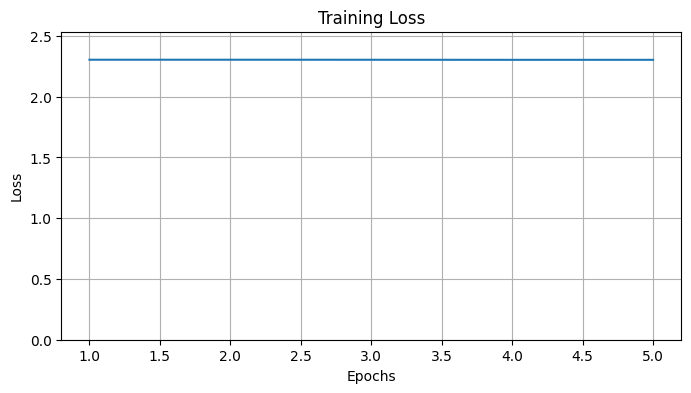

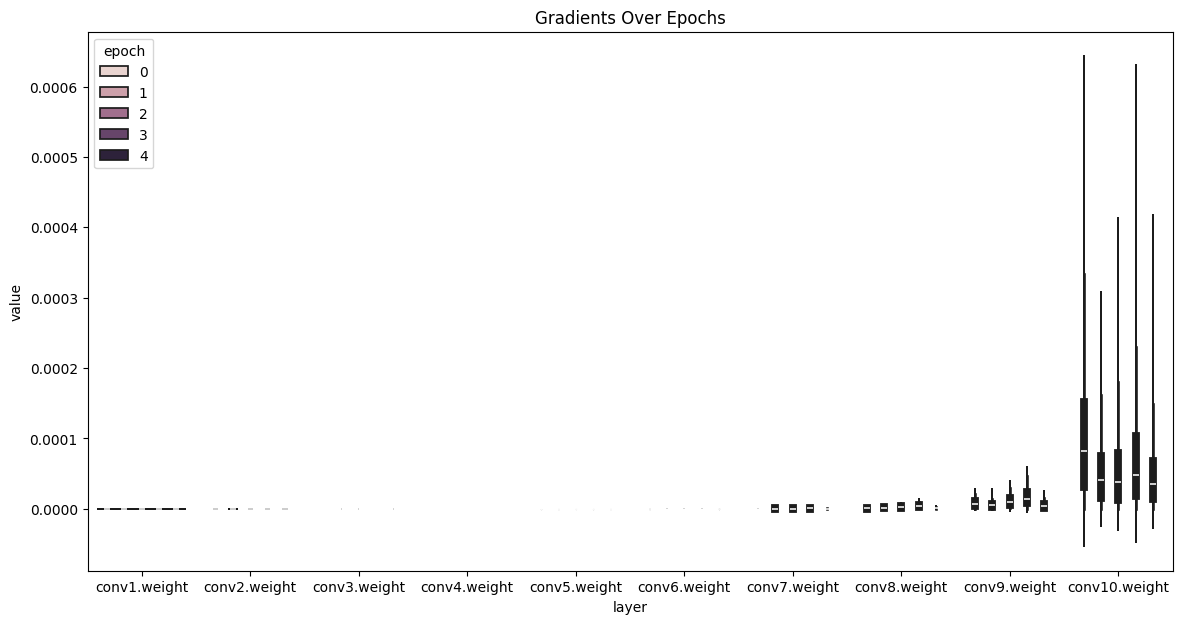

In [ ]:
image_size = (28, 28)
n_channels = 1
n_classes = 10

model = DeepCNN(image_size=image_size, n_channels=n_channels, n_classes=n_classes).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 5
losses = []

gradients = pd.DataFrame(columns=['epoch', 'layer', 'value'])
for epoch in range(num_epochs):
    batch_losses = []
    accuracy_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
        accuracy_metric.update(outputs, labels)

    # Save gradient values
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name and 'weight' in name:
            grad_abs = param.grad.abs().flatten().tolist()
            grad_abs = pd.DataFrame([[epoch, name, g] for g in grad_abs], columns=['epoch', 'layer', 'value'])
            gradients = pd.concat([gradients, grad_abs], ignore_index=True)

    train_loss = np.mean(np.array(batch_losses))
    train_acc = accuracy_metric.compute().item()
    losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

plot_loss_gradient(losses, gradients)

The loss barely changed over the 5 epochs and the accuracy shows that the model performs pooly. This could be a sign of vanishing gradients in deep CNN models.

By visualizing the gradients, we can see the vanishing gradient effect occurs in earlier layers, where gradients are barely visible in layers before `conv8`, which is the last convolutional layer. This corresponds to what we learn in the theory. In back-propagation, the sigmoid activation function can lead to **gradients vanishing** as we pass the derivatives backwards to **earlier layers**.

Over multiple epochs, if earlier layers are not learning meaningful features, later layers may start receiving poor-quality gradients. This can cause **overall model degradation**.

### Batch Normalization

To prevent vanishing gradients, we can apply **batch normalization** to the convolutional layers. Often, we add batch normalization layers **after** convolutional layers and **before** activation function layers.

- [`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html): for 2 dimension layers, can be added to the layers such as `nn.Conv2d`.

In [ ]:
class DeepCNNBatchNorm(nn.Module):
    def __init__(self, image_size, n_channels, n_classes):
        super(DeepCNNBatchNorm, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Batch normalization layers
        self.bn = nn.BatchNorm2d(16)

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.conv10 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.n_channels, self.image_size[0], self.image_size[0])
            dummy_output = torch.sigmoid(self.bn(self.conv1(dummy_input)))
            dummy_output = torch.sigmoid(self.bn(self.conv2(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv3(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv4(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv5(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv6(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv7(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv8(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv9(dummy_output)))
            dummy_output = self.pool((torch.sigmoid(self.bn(self.conv10(dummy_output)))))
            return dummy_output.numel()

    def forward(self, x):
        x = torch.sigmoid(self.bn(self.conv1(x)))
        x = torch.sigmoid(self.bn(self.conv2(x)))
        x = torch.sigmoid(self.bn(self.conv3(x)))
        x = torch.sigmoid(self.bn(self.conv4(x)))
        x = torch.sigmoid(self.bn(self.conv5(x)))
        x = torch.sigmoid(self.bn(self.conv6(x)))
        x = torch.sigmoid(self.bn(self.conv7(x)))
        x = torch.sigmoid(self.bn(self.conv8(x)))
        x = torch.sigmoid(self.bn(self.conv9(x)))
        x = self.pool(torch.sigmoid(self.bn(self.conv10(x))))
        x = x.view(-1, self.flattened_size)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = DeepCNNBatchNorm(image_size=(28, 28), n_channels=1, n_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 16, 28, 28]           2,320
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 28, 28]           2,320
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 16, 28, 28]           2,320
      BatchNorm2d-10           [-1, 16, 28, 28]              32
           Conv2d-11           [-1, 16, 28, 28]           2,320
      BatchNorm2d-12           [-1, 16, 28, 28]              32
           Conv2d-13           [-1, 16, 28, 28]           2,320
      BatchNorm2d-14           [-1, 16,

<ipython-input-25-4ef84ebce63c>:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gradients = pd.concat([gradients, grad_abs], ignore_index=True)


Epoch [1/5], Loss: 1.2923, Accuracy: 55.90%
Epoch [2/5], Loss: 0.2944, Accuracy: 92.21%
Epoch [3/5], Loss: 0.1602, Accuracy: 95.53%
Epoch [4/5], Loss: 0.1193, Accuracy: 96.52%
Epoch [5/5], Loss: 0.1018, Accuracy: 97.02%
Test Accuracy: 97.08%


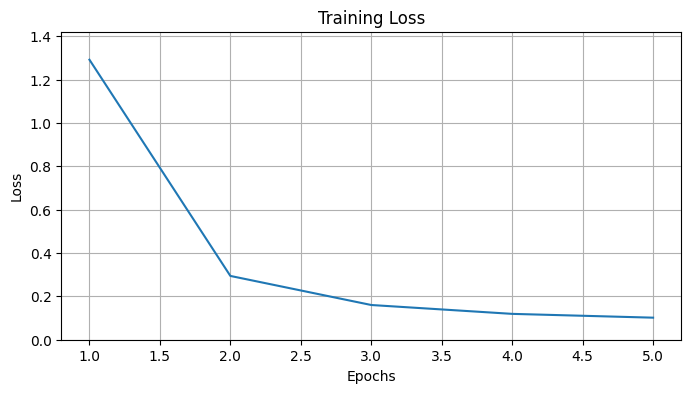

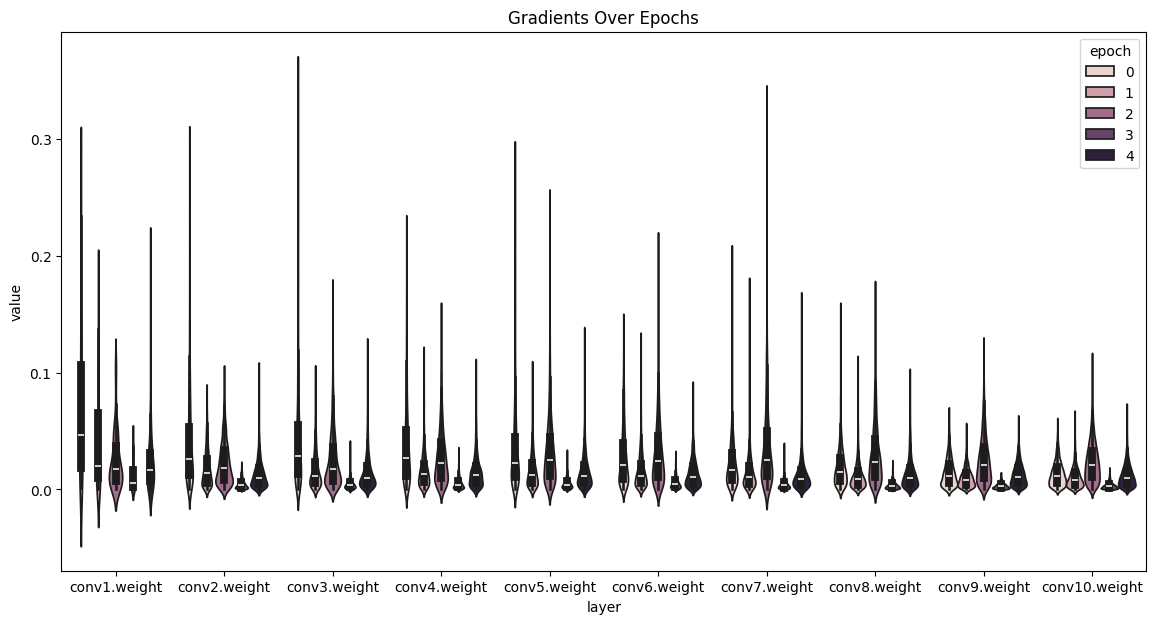

In [ ]:
image_size = (28, 28)
n_channels = 1
n_classes = 10

model = DeepCNNBatchNorm(image_size=image_size, n_channels=n_channels, n_classes=n_classes).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 5
losses = []
gradients = pd.DataFrame(columns=['epoch', 'layer', 'value']) # Save all gradients here for visualization
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    accuracy_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        predicted_classes = torch.argmax(outputs, dim=1)
        accuracy_metric.update(predicted_classes, labels)

    # Save gradients in conv layers
    for name, param in model.named_parameters():
        if param.requires_grad and 'conv' in name and 'weight' in name:
            grad_abs = param.grad.abs().flatten().tolist()
            grad_abs = pd.DataFrame([[epoch, name, g] for g in grad_abs], columns=['epoch', 'layer', 'value'])
            gradients = pd.concat([gradients, grad_abs], ignore_index=True)

    train_loss = np.mean(np.array(batch_losses))
    train_acc = accuracy_metric.compute().item()
    losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        accuracy_metric.update(outputs, labels)
    test_acc = accuracy_metric.compute().item()
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Visualize the results
plot_loss_gradient(losses, gradients)


We see significant improvements in accuracy and loss with batch normalization. The values of gradients also suggest a healthier back-propagation.

### Dropout Layer

Dropout is a regularization technique used in neural networks to prevent overfitting by randomly deactivating a fraction of neurons during training. By temporarily removing neurons, dropout forces the network to learn more robust features that better generaliz to unseen data. In CNNs, dropout is typically applied to fully connected layers rather than convolutional layers, as convolutional layers already are parameter-light from weight sharing and local feature extraction.

- [`nn.Dropout(p=0.2)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html): we set `p` to assign the probability of a neuron being dropped.

When evaluating the model, we **don't** want dropout. The line `model.eval()` ensures that dropout is turned off and that the full network is used for inference. When using `nn.Dropout`, PyTorch automatically scales activations at training time, so at inference time, you don’t need to worry about neural size mismatch. However, if you manually coded dropout, you would need to scale activations during either training or inference to account for this mismatch.



In [ ]:
class DeepCNNDropout(nn.Module):
    def __init__(self, image_size, n_channels, n_classes):
        super(DeepCNNDropout, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Batch normalization layers
        self.bn = nn.BatchNorm2d(16)

        # Dropout layers
        self.dropout = nn.Dropout(p=0.1)

        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.conv10 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flattened_size = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, n_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.n_channels, self.image_size[0], self.image_size[0])
            dummy_output = torch.sigmoid(self.bn(self.conv1(dummy_input)))
            dummy_output = torch.sigmoid(self.bn(self.conv2(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv3(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv4(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv5(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv6(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv7(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv8(dummy_output)))
            dummy_output = torch.sigmoid(self.bn(self.conv9(dummy_output)))
            dummy_output = self.pool((torch.sigmoid(self.bn(self.conv10(dummy_output)))))
            return dummy_output.numel()

    def forward(self, x):
        x = torch.sigmoid(self.bn(self.conv1(x)))
        x = torch.sigmoid(self.bn(self.conv2(x)))
        x = torch.sigmoid(self.bn(self.conv3(x)))
        x = torch.sigmoid(self.bn(self.conv4(x)))
        x = torch.sigmoid(self.bn(self.conv5(x)))
        x = torch.sigmoid(self.bn(self.conv6(x)))
        x = torch.sigmoid(self.bn(self.conv7(x)))
        x = torch.sigmoid(self.bn(self.conv8(x)))
        x = torch.sigmoid(self.bn(self.conv9(x)))
        x = self.pool(torch.sigmoid(self.bn(self.conv10(x))))
        x = x.view(-1, self.flattened_size)
        x = self.dropout(torch.sigmoid(self.fc1(x))) # add dropout to fc layer
        x = self.dropout(torch.sigmoid(self.fc2(x))) # add dropout to fc layer
        x = self.fc3(x)
        return x

In [ ]:
model = DeepCNNDropout(image_size=(28, 28), n_channels=1, n_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 16, 28, 28]           2,320
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 28, 28]           2,320
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 16, 28, 28]           2,320
      BatchNorm2d-10           [-1, 16, 28, 28]              32
           Conv2d-11           [-1, 16, 28, 28]           2,320
      BatchNorm2d-12           [-1, 16, 28, 28]              32
           Conv2d-13           [-1, 16, 28, 28]           2,320
      BatchNorm2d-14           [-1, 16,

In [ ]:
image_size = (28, 28)
n_channels = 1
n_classes = 10

model = DeepCNNDropout(image_size=image_size, n_channels=n_channels, n_classes=n_classes).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 5
losses = []
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    accuracy_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        predicted_classes = torch.argmax(outputs, dim=1)
        accuracy_metric.update(predicted_classes, labels)

    train_loss = np.mean(np.array(batch_losses))
    train_acc = accuracy_metric.compute().item()
    losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

model.eval() # disable dropout layers
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        accuracy_metric.update(outputs, labels)
    test_acc = accuracy_metric.compute().item()

print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch [1/5], Loss: 1.2511, Accuracy: 59.78%
Epoch [2/5], Loss: 0.2194, Accuracy: 94.14%
Epoch [3/5], Loss: 0.1377, Accuracy: 96.14%
Epoch [4/5], Loss: 0.1118, Accuracy: 96.69%
Epoch [5/5], Loss: 0.0931, Accuracy: 97.23%
Test Accuracy: 84.71%


## Deep Residual Networks

Residual blocks were introduced to cope with the deep network degradation problem. To implement one, we will develop a `residual_block(self, x, conv1, conv2, bn)` for $F(x) + x$.  

In [ ]:
import torch
import torch.nn as nn

class ResidualCNN(nn.Module):
    def __init__(self, image_size, n_channels, n_classes):
        super(ResidualCNN, self).__init__()

        self.image_size = image_size
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.bn = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def residual_block(self, x, conv1, conv2, bn):
        residual = x  # Save input for residual connection
        x = torch.relu(bn(conv1(x)))
        x = bn(conv2(x))
        x += residual  # Add residual connection
        return torch.relu(x)  # Apply activation

    def forward(self, x):
        x = torch.relu(self.bn(self.conv1(x)))
        x = torch.relu(self.bn(self.conv2(x)))
        x = self.residual_block(x, self.conv3, self.conv4, self.bn) # residual 1
        x = self.residual_block(x, self.conv5, self.conv6, self.bn) # residual 2
        x = self.residual_block(x, self.conv7, self.conv8, self.bn) # residual 3
        x = self.residual_block(x, self.conv9, self.conv10, self.bn) # residual 4
        x = self.pool(x)
        x = x.view(-1, 16 * 14 * 14)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = ResidualCNN(image_size=(28, 28), n_channels=1, n_classes=10).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 16, 28, 28]           2,320
       BatchNorm2d-4           [-1, 16, 28, 28]              32
            Conv2d-5           [-1, 16, 28, 28]           2,320
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7           [-1, 16, 28, 28]           2,320
       BatchNorm2d-8           [-1, 16, 28, 28]              32
            Conv2d-9           [-1, 16, 28, 28]           2,320
      BatchNorm2d-10           [-1, 16, 28, 28]              32
           Conv2d-11           [-1, 16, 28, 28]           2,320
      BatchNorm2d-12           [-1, 16, 28, 28]              32
           Conv2d-13           [-1, 16, 28, 28]           2,320
      BatchNorm2d-14           [-1, 16,

In [ ]:
image_size = (28, 28)
n_channels = 1
n_classes = 10

model = ResidualCNN(image_size=image_size, n_channels=n_channels, n_classes=n_classes).to(device)

loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 5
losses = []
gradients = {name:[] for name, param in model.named_parameters() if 'conv' in name and 'weight' in name}
for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    accuracy_metric.reset()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

        predicted_classes = torch.argmax(outputs, dim=1)
        accuracy_metric.update(predicted_classes, labels)

    train_loss = np.mean(np.array(batch_losses))
    train_acc = accuracy_metric.compute().item()
    losses.append(train_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

# Evaluation
with torch.no_grad():
    accuracy_metric.reset()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted_classes = torch.argmax(outputs, dim=1)
        accuracy_metric.update(predicted_classes, labels)

    test_acc = accuracy_metric.compute().item()

print(f"Evaluation results - Train Accuracy: {train_acc*100:.2f}%, Test Accuracy: {test_acc*100:.2f}%")


Epoch [1/5], Loss: 0.2558, Accuracy: 92.83%
Epoch [2/5], Loss: 0.0529, Accuracy: 98.38%
Epoch [3/5], Loss: 0.0379, Accuracy: 98.84%
Epoch [4/5], Loss: 0.0315, Accuracy: 98.99%
Epoch [5/5], Loss: 0.0289, Accuracy: 99.08%
Evaluation results - Train Accuracy: 99.08%, Test Accuracy: 98.86%


From a quick comparison to the model `DeepCNNImproved`, we can see `ResidualCNN` performs better after five training epochs.

### Pretrained ResNet

Finally, we'll learn how to load a **pretrained** ResNet model from `torchvision`. For image classification, here is an [index](https://pytorch.org/vision/0.20/models.html) of what pre-trained models are available. If you click on [ResNet](https://pytorch.org/vision/0.20/models/resnet.html#resnet), there is a list of architectures including `resnet18`, `resnet50`, etc.

If you go to the architecture page, there will be information on the pretrained weights. For example, in [`resnet18`](https://pytorch.org/vision/0.20/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18), you will see that the pretrained weights `ResNet18_Weights.IMAGENET1K_V1` is trained on ImageNet-10K and it's benchmark performance.

In [ ]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(device)
summary(model, input_size=(3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.9MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Test this model by passing in an image to the pre-trained model.

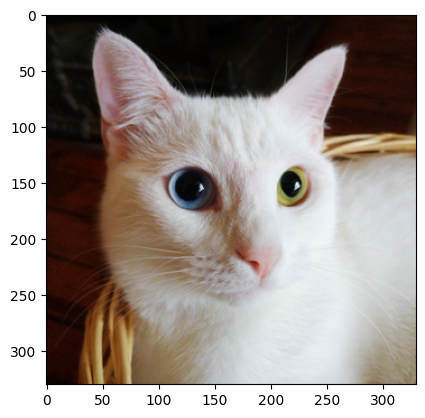

Predicted: Siamese cat (29.33%)


In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Step 1: Load image from URL
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/VAN_CAT.png/330px-VAN_CAT.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")  # Ensure it's RGB
plt.imshow(img) # plot the image
plt.show()

# Step 2: Initialize model with the best available weights
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model = torchvision.models.resnet18(weights=weights)
model.eval()

# Step 3: Initialize the inference preprocessing transforms
preprocess = weights.transforms()

# Step 4: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)  # Add batch dimension

# Step 5: Use the model and print the predicted category
with torch.no_grad():
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]

print(f"Predicted: {category_name} ({100 * score:.2f}%)")

## Review

As shown, training CNN models can be time-consuming and resource-consuming. The skill in identifying issues in an early architectural design stage is incredibly valuable for reducing your trial-and-error time. We saw in this tutorial that techniques such as batch normalization, dropout, and residual connections can help!

For next steps, try the following:
- Load the dataset with a different batch size
- Build a 5-layer CNN model and observe if there is a vanishing gradient effect
- Use ReLU activation function in your model. What changes do you see in the gradients?

For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :) See you in the next tutorial!

\- Everley